In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence
from signature.signature.stationary_signature import stationary_signature_from_path, G, discount_ts
from signature.signature.expected_signature import expected_signature, expected_stationary_signature

from simulation.diffusion import Diffusion

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 6, 6)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True

In [2]:
N = 9

In [3]:
%%time
ta = TensorAlgebra(dim=2, trunc=N)

Compiling...
Compilation finished.
CPU times: total: 6min 21s
Wall time: 7min 10s


In [311]:
e0 = ta.from_dict({"": 1}, trunc=N)

e1 = ta.from_dict({"1": 1}, trunc=N)
e2 = ta.from_dict({"2": 1}, trunc=N)

e11 = ta.from_dict({"11": 1}, trunc=N)
e12 = ta.from_dict({"12": 1}, trunc=N)
e21 = ta.from_dict({"21": 1}, trunc=N)
e22 = ta.from_dict({"22": 1}, trunc=N)

e212 = ta.from_dict({"212": 1}, trunc=N)
e222 = ta.from_dict({"222": 1}, trunc=N)

## Stationary Signature of signal

In [150]:
T = 50
t_grid = np.linspace(-T, T, 10000 + 1)
t_grid_pos = t_grid[t_grid >= 0]
rng = np.random.default_rng(seed=50)

lam = 3
size = 2

In [151]:
%%time
diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]
path = np.vstack([t_grid, W]).T
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_grid, lam=lam)

W2 = diffusion.brownian_motion()[1, 0, :]
path2 = np.vstack([t_grid, W2]).T
SigS_test = stationary_signature_from_path(path=path2, trunc=trunc_moments, t_grid=t_grid, lam=lam)

CPU times: total: 29 s
Wall time: 31.2 s


In [298]:
ell = e2 + e22 * 2
ell_SigS = (ell @ SigS).squeeze().real
ell_SigS_test = (ell @ SigS_test).squeeze().real

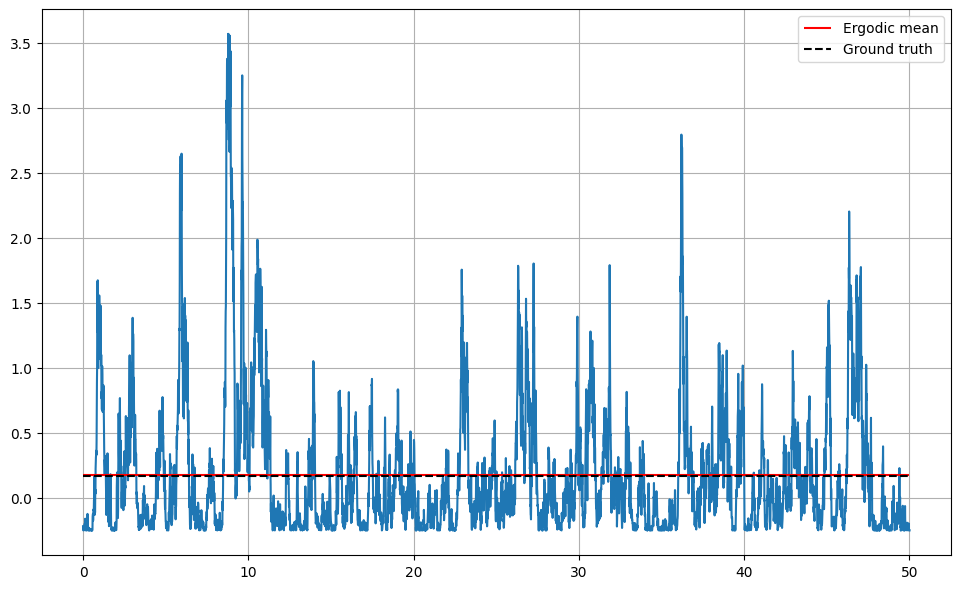

In [301]:
plt.plot(t_grid_pos, ell_SigS)

plt.hlines(ell_SigS.mean(), t_grid_pos[0], t_grid_pos[-1], "r", label="Ergodic mean")
plt.hlines(1 / 2 / lam, t_grid_pos[0], t_grid_pos[-1], "k", linestyles="--", label="Ground truth")

plt.legend()

#### Calculating the signature of signal

In [14]:
%%time
signal = ell_SigS.real

path_signal = np.empty((len(t_grid_pos), 2))
path_signal[:, 0] = t_grid_pos
path_signal[:, 1] = signal

SignalSigS = stationary_signature_from_path(path=path_signal, trunc=N, t_grid=t_grid_pos - 15, lam=lam)

t_grid_s = t_grid_pos[t_grid_pos >= 15]

CPU times: total: 11.4 s
Wall time: 12 s


In [91]:
trunc_moments = 3
n_moments = ta.alphabet.number_of_elements(trunc_moments)
words = [ta.alphabet.index_to_word(idx) for idx in range(n_moments)]

n_moments

15

In [21]:
def resolvent(mu, lam, ts):
    tmp = ts * 1
    res = ts * 1
    for i in range(N):
        tmp.update(G(tmp) * lam - tmp * mu)
        tmp.update(tmp.tensor_prod_word("1"))
        res.update(res + tmp)

    return res

In [22]:
def signal_stat_signature_coefs_as_bm_stat_signature_coefs(ts, trunc_moments):
    signal_sig_coefs_exact = dict()
    n_moments = ta.alphabet.number_of_elements(trunc_moments)

    for idx in range(n_moments):
        word = ta.alphabet.index_to_word(idx)
        if not idx:
            signal_sig_coefs_exact[""] = TensorSequence.unit(ta.alphabet, N)
        else:
            if word.endswith("1"):
                signal_sig_coefs_exact[word] = resolvent(mu=len(word) * lam, lam=lam, ts=signal_sig_coefs_exact[word[:-1]].tensor_prod_word("1"))
            elif word.endswith("2"):
                coef_prev = signal_sig_coefs_exact[word[:-1]]
                c = (ta.shuop.shuffle_prod(coef_prev, ts.proj("1") - G(ts) * lam) - ta.shuop.shuffle_prod(coef_prev.proj("2") / 2, ts.proj("2"))).tensor_prod_word("1") + \
                    ta.shuop.shuffle_prod(coef_prev, ts.proj("2")).tensor_prod_word("2")
                signal_sig_coefs_exact[word] = resolvent(mu=len(word) * lam, lam=lam, ts=c)
    return signal_sig_coefs_exact

In [23]:
%%time
signal_stat_sig_coefs_exact = signal_stat_signature_coefs_as_bm_stat_signature_coefs(ell, trunc_moments)

CPU times: total: 5.41 s
Wall time: 6.2 s


In [24]:
ta.print(signal_stat_sig_coefs_exact["222"])

-1.0*22122 + -3.0*22212 + -6.0*22221 + -3.0*221122 + -3.0*221212 + 3.0*221221 + -9.0*222112 + 9.0*222121 + 18.0*222211 + 15.0*222222 + -18.0*2211122 + -18.0*2211212 + 9.0*2211221 + -18.0*2212112 + 9.0*2212121 + 63.0*2212211 + -9.0*2212222 + -54.0*2221112 + 27.0*2221121 + 189.0*2221211 + -27.0*2221222 + 378.0*2222111 + -54.0*2222122 + -90.0*2222212 + -135.0*2222221 + -162.0*22111122 + -162.0*22111212 + 54.0*22111221 + -162.0*22112112 + 54.0*22112121 + 378.0*22112211 + -54.0*22112222 + -162.0*22121112 + 54.0*22121121 + 378.0*22121211 + -54.0*22121222 + 1026.0*22122111 + -45.0*22122122 + -27.0*22122212 + -486.0*22211112 + 162.0*22211121 + 1134.0*22211211 + -162.0*22211222 + 3078.0*22212111 + -135.0*22212122 + -81.0*22212212 + 6156.0*22221111 + -270.0*22221122 + -162.0*22221212 + -270.0*22222112 + -1944.0*221111122 + -1944.0*221111212 + 486.0*221111221 + -1944.0*221112112 + 486.0*221112121 + 3726.0*221112211 + -486.0*221112222 + -1944.0*221121112 + 486.0*221121121 + 3726.0*221121211 + -486

In [25]:
SigS.array.shape

(1023, 5001, 1)

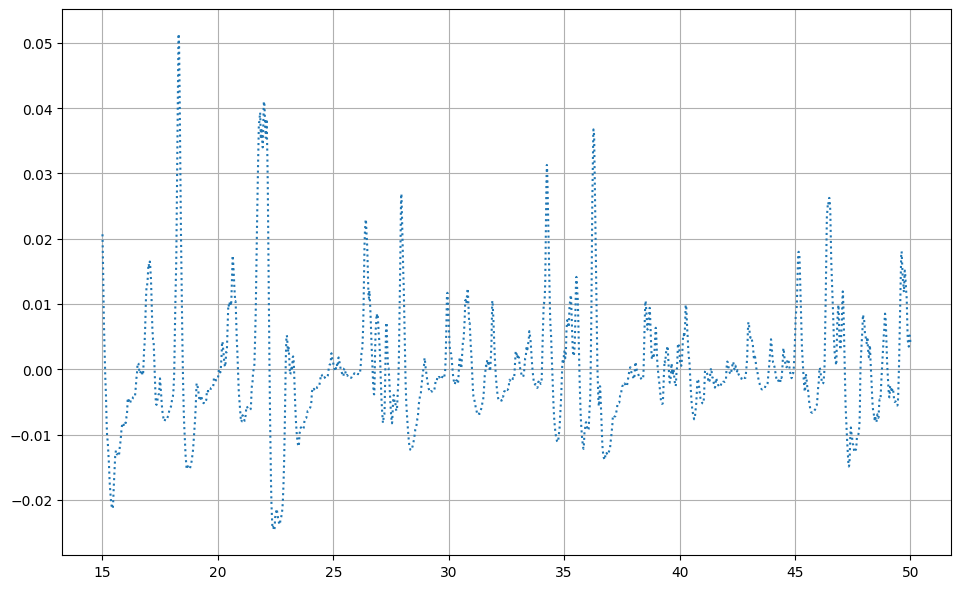

In [30]:
# plt.plot(t_grid_s, (signal_stat_sig_coefs_exact["222"] @ SigS).squeeze()[t_grid_pos >= 15])
plt.plot(t_grid_s, (e21 @ SignalSigS), ":")

In [31]:
%%time
eSigS = expected_stationary_signature(lam=lam, trunc=N)

CPU times: total: 5.41 s
Wall time: 8.23 s


In [281]:
%%time

expected_signal_stat_sig_estimator = dict()
expected_signal_stat_sig_exact = dict()

for idx in range(n_moments):
    word = ta.alphabet.index_to_word(idx)
    if word == "∅":
        word = ""
    expected_signal_stat_sig_estimator[word] = SignalSigS.array[idx].mean()
    expected_signal_stat_sig_exact[word] = (signal_stat_sig_coefs_exact[word] @ eSigS).squeeze()

CPU times: total: 0 ns
Wall time: 0 ns


In [283]:
w = "2"
expected_signal_stat_sig_estimator[w], expected_signal_stat_sig_exact[w]

((1.4819416621710028e-05+0j), array(0.00833333+0.j))

##### Loss functional for a given $l$

In [289]:
ell_trunc = 3

def loss_stat(x):    
    l = ta.from_array(N, x)
    signal_stat_sig_coefs = signal_stat_signature_coefs_as_bm_stat_signature_coefs(l, trunc_moments)
    
    loss = 0
    for word in words:
        if "2" in word:
            # Moments are supposed to be known exactly
            loss_word = np.sqrt(np.mean(np.abs((signal_stat_sig_coefs[word] @ eSigS).squeeze() - expected_signal_stat_sig_exact[word])**2))
            loss += loss_word
    
    return loss

In [290]:
x0 = np.zeros(ta.alphabet.number_of_elements(ell_trunc))

In [291]:
%%time
loss_stat(x0)

CPU times: total: 46.9 ms
Wall time: 94.2 ms


0.010321093750000001

In [293]:
%%time

from scipy.optimize import minimize

def callback(x, f=None, context=None, accept=None, convergence=None):
    val = loss_stat(x)
    print(f"New iteration: \n x = {x}, \n val={val}. \n")

res = minimize(loss_stat, x0, callback=callback, method="BFGS")
print(res)

New iteration: 
 x = [ 0.00000000e+00  3.02261860e-01 -3.10481573e-09  3.02261868e-02
  0.00000000e+00  0.00000000e+00  1.25294210e-01  1.51130787e-03
  0.00000000e+00  0.00000000e+00  1.25294218e-02  0.00000000e+00
  0.00000000e+00  6.26471089e-03  0.00000000e+00], 
 val=0.0022176860482609755. 

New iteration: 
 x = [ 0.00000000e+00  3.51610595e-01 -3.54563448e-09  3.51757401e-02
  0.00000000e+00  0.00000000e+00  1.45847824e-01  1.75944838e-03
  0.00000000e+00  0.00000000e+00  1.45880485e-02  0.00000000e+00
  1.26712280e-06  7.29250426e-03  0.00000000e+00], 
 val=0.0011075077325957319. 

New iteration: 
 x = [ 0.00000000e+00  3.51610598e-01 -3.54563451e-09  3.51757406e-02
 -5.11220152e-18  0.00000000e+00  1.45847825e-01  1.75944840e-03
  0.00000000e+00  0.00000000e+00  1.45880487e-02  0.00000000e+00
  1.26712333e-06  7.29250436e-03 -1.70406717e-18], 
 val=0.0011075076513443784. 

New iteration: 
 x = [ 0.00000000e+00  3.51610598e-01 -3.54563442e-09  3.51757427e-02
 -1.42969984e-17  0.

In [295]:
l_opt = ta.from_array(moments_trunc, res.x)
ta.print(l_opt)

0.3516105983634915*1 + 0.03517576155534584*11 + 0.14584783466533074*22 + 0.0017595189129007553*111 + 0.014588074290246009*122 + 1.28419076285507e-06*212 + 0.007292498171109511*221


In [298]:
l_SigS = l_opt @ SigS

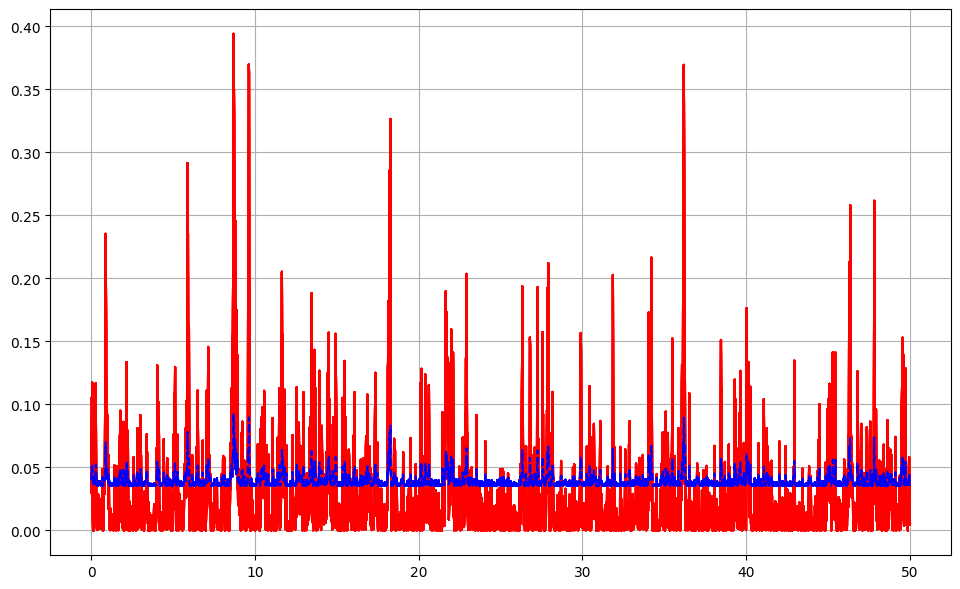

In [299]:
for i in range(10):
    plt.plot(t_grid_pos, ell_SigS, "r")
    plt.plot(t_grid_pos, l_SigS, "b--")

# Standard signatures of the stationary signal

In [443]:
trunc_model = 3
trunc_moments = 4

In [487]:
T = 100
t_grid = np.linspace(-T, T, 10000 + 1)
t_grid_pos = t_grid[t_grid >= 0]
rng = np.random.default_rng(seed=50)

lam = 3
size = 2

In [488]:
%%time
diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]
path = np.vstack([t_grid, W]).T
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_grid, lam=lam)

W2 = diffusion.brownian_motion()[1, 0, :]
path2 = np.vstack([t_grid, W2]).T
SigS_test = stationary_signature_from_path(path=path2, trunc=trunc_moments, t_grid=t_grid, lam=lam)

CPU times: total: 21.9 s
Wall time: 25.4 s


In [489]:
ell = e2
ell_SigS = (ell @ SigS).squeeze().real
ell_SigS_test = (ell @ SigS_test).squeeze().real

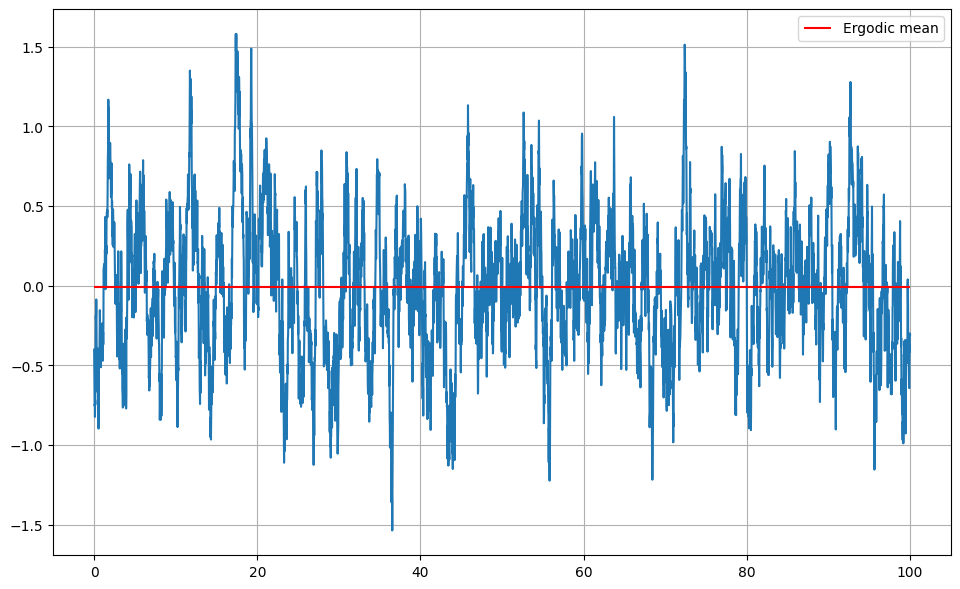

In [490]:
plt.plot(t_grid_pos, ell_SigS)

plt.hlines(ell_SigS.mean(), t_grid_pos[0], t_grid_pos[-1], "r", label="Ergodic mean")

plt.legend()

In [491]:
%%time

win_size = 100
idx_start = 0
num_of_win = len(t_grid_pos) - win_size

signal = (ell @ SigS).real.squeeze()
path_signal = np.empty((win_size, 2, num_of_win))

path_signal[:, 0, :] = np.tile(t_grid_pos[:win_size][:, None], num_of_win)
for idx_start in range(num_of_win):
    path_signal[:, 1, idx_start] = signal[idx_start:idx_start + win_size]

SignalSig = ta.path_to_sequence(path=path_signal, trunc=trunc_moments)
exp_sig_emp = SignalSig.array.mean(axis=2).real

CPU times: total: 359 ms
Wall time: 503 ms


In [492]:
mask = [2, 5, 6, 8, 10, 12, 14]

def l_from_x(x):
    array = np.zeros(ta.alphabet.number_of_elements(trunc_model))
    array[mask] = x
    l = ta.from_array(trunc=trunc_model, array=array)
    return l
    
def mc_loss(x):
    l = l_from_x(x)
    
    l_SigS = (l @ SigS_test).squeeze().real
    
    signal_l = l_SigS.real
    path_signal_l = np.empty((win_size, 2, num_of_win))
    path_signal_l[:, 0, :] = np.tile(t_grid_pos[:win_size][:, None], num_of_win)
    for idx_start in range(num_of_win):
        path_signal_l[:, 1, idx_start] = signal_l[idx_start:idx_start + win_size]

    SignalSig_l = ta.path_to_sequence(path=path_signal_l, trunc=trunc_moments)
    exp_sig_emp_l = SignalSig_l.array.mean(axis=2).real

    return np.mean((exp_sig_emp - exp_sig_emp_l)**2)

In [493]:
%%time

rng = np.random.default_rng(seed=42)
x0 = rng.normal(size=7) * 0.0
x0[0] = 0.01

mc_loss(x0)

CPU times: total: 469 ms
Wall time: 439 ms


0.004595720466332338

In [494]:
x_exact = np.eye(1, 7, k=0)[0]
ta.print(l_from_x(x_exact))
mc_loss(x_exact)

1.0*2


0.00011979243379580594

In [495]:
%%time

from scipy.optimize import minimize

def callback(x, f=None, context=None, accept=None, convergence=None):
    val = mc_loss(x)
    print(f"New iteration: \n x = {x}, \n val={val}. \n")

res = minimize(mc_loss, x0, callback=callback, method="BFGS")
print(res)

New iteration: 
 x = [ 1.05993957  0.09039951  0.00109308  0.03360577 -0.00259698  0.00294412
  0.08687022], 
 val=3.382180218995205e-05. 

New iteration: 
 x = [ 1.05985177  0.09039202  0.00109315  0.03360295 -0.00259673  0.00294389
  0.08686296], 
 val=3.382167644892732e-05. 

New iteration: 
 x = [1.0555056  0.14601068 0.13441242 0.02308572 0.02366914 0.01348278
 0.09066628], 
 val=2.929872434198312e-05. 

New iteration: 
 x = [1.04528374 0.24122966 0.36318577 0.00494685 0.06874784 0.03155974
 0.09696718], 
 val=2.6441183496989955e-05. 

New iteration: 
 x = [1.04112739 0.23925073 0.35928536 0.00511428 0.0679906  0.03123962
 0.09650334], 
 val=2.6083883068039432e-05. 

New iteration: 
 x = [1.03954063 0.24641399 0.37662261 0.00371048 0.07140858 0.03260725
 0.09691523], 
 val=2.6060939144178773e-05. 

New iteration: 
 x = [1.03928893 0.24768411 0.3796553  0.00346299 0.072006   0.03284647
 0.09699061], 
 val=2.606023694693271e-05. 

New iteration: 
 x = [1.03922917 0.24797649 0.380311

##### Target coefficients:

In [496]:
ta.print(ell)

1.0*2


##### Calibrated coefficients:

In [497]:
l_opt = l_from_x(res.x)
ta.print(l_opt)

0.8494081153968591*2 + 2.289942299229162*21 + 0.3145953724369025*22 + -0.3845807119777345*112 + 0.004537471595712311*122 + 0.015889478348323195*212 + 0.24715371071570277*222


In [498]:
ell_SigS = (ell @ SigS).squeeze().real
l_opt_SigS = (l_opt @ SigS).squeeze().real

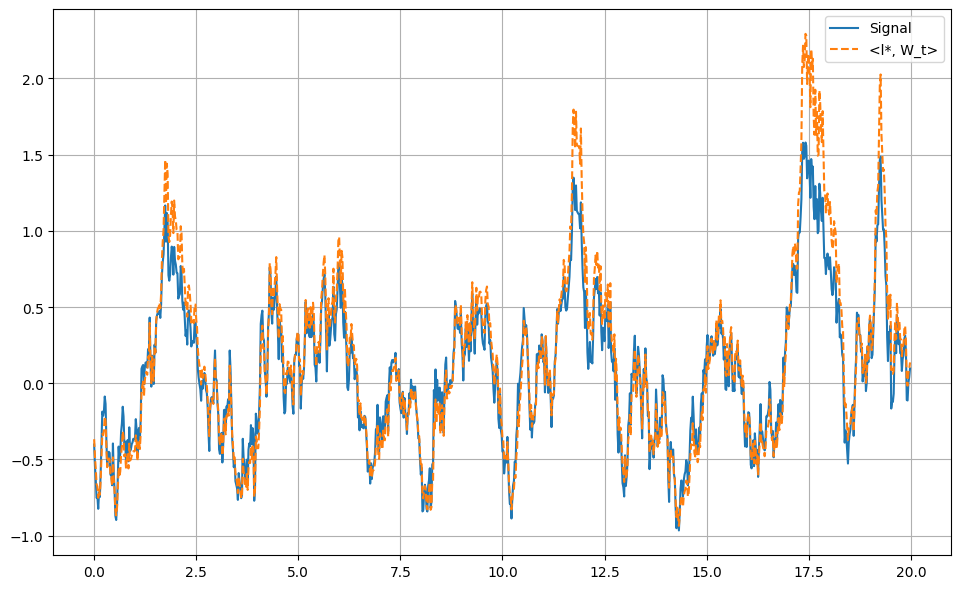

In [499]:
n = 1000

plt.plot(t_grid_pos[:n], ell_SigS[:n], label="Signal")
plt.plot(t_grid_pos[:n], l_opt_SigS[:n], "--", label="<l*, W_t>")

plt.legend()

#### Strip the BM

In [500]:
from numba import jit
from signature.signature.numba_utility import factorial

@jit(nopython=True)
def h(dt: float, n: int, lam: float):
    """
    Calculates a stationary lambda-signature of order n of the path X_t = t on [0, dt].
    """
    if np.isclose(lam, 0):
        return dt**n / factorial(n)
    else:
        return ((1 - np.exp(-lam * dt)) / lam)**n / factorial(n)

def get_step_signature(dt, dW, trunc=5, lam=0):
    dim = 2
    alphabet = ta.alphabet
    
    path_inc = np.array([dt, dW / dt])
    
    n_indices = alphabet.number_of_elements(trunc)
    array_step = np.zeros(n_indices)
    array_step[0] = 1
    
    for n in range(1, trunc + 1):
        tp_n = path_inc
        for i in range(n - 1):
            inc_shape = (1,) * len(tp_n.shape) + (dim,)
            tp_n = tp_n.reshape(tp_n.shape + (1,)) * path_inc.reshape(inc_shape)
    
        idx_start = alphabet.number_of_elements(n - 1)
        array_step[idx_start:idx_start + dim ** n] = tp_n.reshape((-1,)).T * h(dt=dt, n=n, lam=lam)
    
    return ta.from_array(trunc=trunc, array=array_step)

In [501]:
from tqdm import tqdm

def strip_bm_path(signal, l, t_grid, lam, trunc=3):
    rng = np.random.default_rng(seed=42)
    dt = np.diff(t_grid)

    path_sig = ta.from_array(trunc=trunc, array=np.ones(1))
    dW = np.zeros(t_grid.size - 1)
    
    for i in tqdm(range(1, len(t_grid))):
        def loss(x):
            return np.abs(l @ discount_ts(path_sig, dt=dt[i - 1], lam=lam).tensor_prod(get_step_signature(dt[i - 1], x[0], trunc=trunc, lam=lam)) - signal[i]).squeeze()**2
        if loss([0]) == loss([1]):
            return np.nan
        std = np.sqrt(dt[i - 1])
        res = minimize(loss, x0=[rng.normal() * std / 10], method="BFGS", bounds=[(-5 * std, 5 * std)])
        dW[i - 1] = res.x[0]
        step_sig = get_step_signature(dt[i - 1], res.x[0], trunc=5, lam=lam)
        path_sig = discount_ts(path_sig, dt=dt[i - 1], lam=lam).tensor_prod(step_sig)
    return np.concatenate([[0], np.cumsum(dW)])

In [502]:
W_strip = strip_bm_path(signal, ell, t_grid_pos, lam)

  0%|                                                                         | 0/5000 [00:00<?, ?it/s]C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
100%|█████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 440.13it/s]


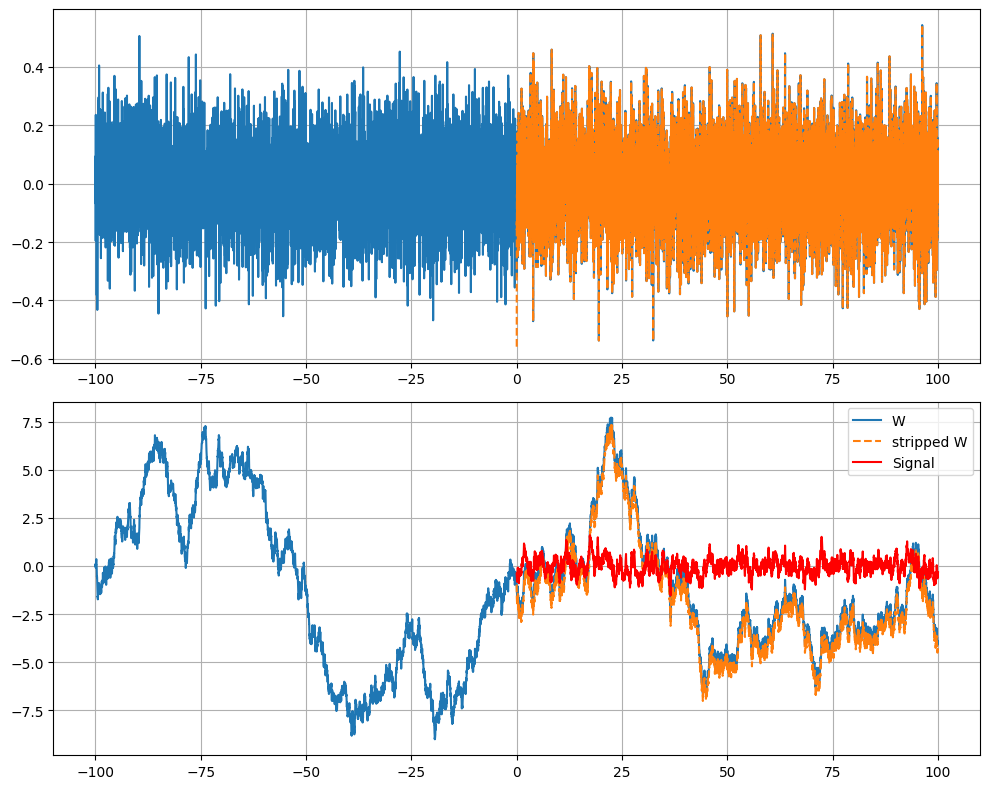

In [503]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(t_grid[1:], np.diff(W))
ax[0].plot(t_grid_pos[1:], np.diff(W_strip), "--")

ax[1].plot(t_grid, W, label="W")
ax[1].plot(t_grid_pos, W_strip - W_strip[0] + W[np.where(t_grid >= 0)[0][0]], "--", label="stripped W")

ax[1].plot(t_grid_pos, signal, 'r', label="Signal")

plt.legend()

# Standard Signatures

In [7]:
T = 4
t_grid = np.linspace(-T, T, 200 + 1)
rng = np.random.default_rng(seed=50)

lam = 10
size = 10

In [8]:
%%time
t_grid_pos = t_grid[t_grid >= 0]

diffusion = Diffusion(t_grid=t_grid_pos, size=size, rng=rng)

path_pos = np.empty((len(t_grid_pos), 2, size))
path_pos[:, 0, :] = np.tile(t_grid_pos[:, None], size)
path_pos[:, 1, :] = diffusion.brownian_motion()[:, 0, :].T

Sig = ta.path_to_sequence(path=path_pos, trunc=N)

CPU times: total: 0 ns
Wall time: 31.3 ms


In [9]:
ell = _22
ell_Sig = (ell @ Sig)

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


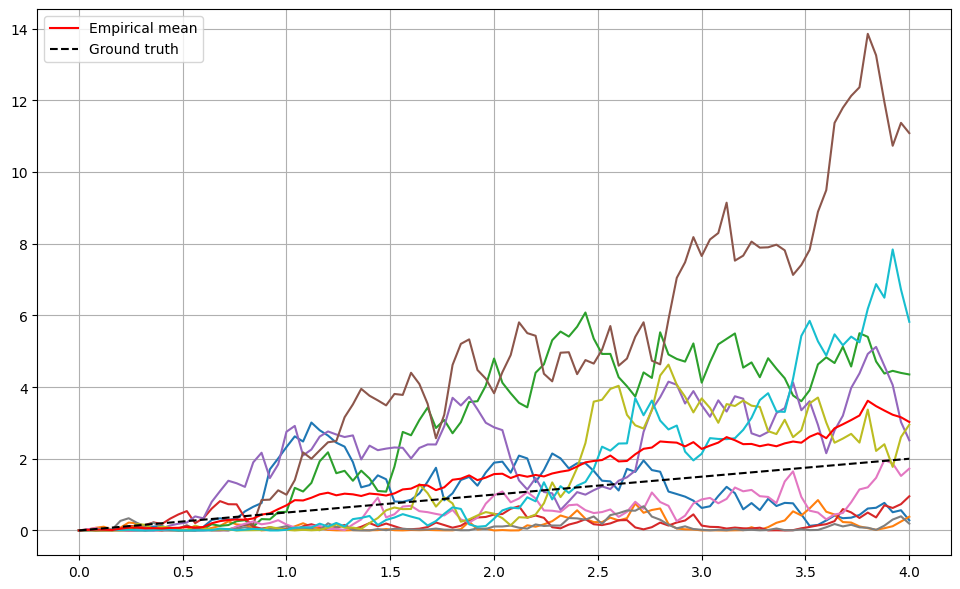

In [10]:
for i in range(10):
    plt.plot(t_grid_pos, ell_Sig[:, i])

plt.plot(t_grid_pos, ell_Sig.mean(axis=1), "r", label="Empirical mean")
plt.plot(t_grid_pos, t_grid_pos / 2, "k--", label="Ground truth")
plt.legend()

#### Calculating the signature of signal

In [11]:
%%time
signal = ell_Sig.real

path_signal = np.empty((len(t_grid_pos), 2, size))
path_signal[:, 0, :] = np.tile(t_grid_pos[:, None], size)
path_signal[:, 1, :] = signal

SignalSig = ta.path_to_sequence(path=path_signal, trunc=N)

CPU times: total: 31.2 ms
Wall time: 28.7 ms


In [59]:
trunc_moments = 3
n_moments = ta.alphabet.number_of_elements(trunc_moments)
words = [ta.alphabet.index_to_word(idx) for idx in range(n_moments)]

n_moments, words

(15,
 ['∅',
  '1',
  '2',
  '11',
  '12',
  '21',
  '22',
  '111',
  '112',
  '121',
  '122',
  '211',
  '212',
  '221',
  '222'])

In [49]:
def signal_signature_coefs_as_bm_signature_coefs(ts, trunc_moments):
    signal_sig_coefs_exact = dict()
    n_moments = ta.alphabet.number_of_elements(trunc_moments)

    for idx in range(n_moments):
        word = ta.alphabet.index_to_word(idx)
        if not idx:
            signal_sig_coefs_exact[""] = TensorSequence.unit(ta.alphabet, N)
        else:
            if word.endswith("1"):
                signal_sig_coefs_exact[word] = signal_sig_coefs_exact[word[:-1]].tensor_prod_word("1")
            elif word.endswith("2"):
                signal_sig_coefs_exact[word] = ta.shuop.shuffle_prod(signal_sig_coefs_exact[word[:-1]], ts.proj("1")).tensor_prod_word("1") + \
                                               ta.shuop.shuffle_prod(signal_sig_coefs_exact[word[:-1]], ts.proj("2")).tensor_prod_word("2")
    return signal_sig_coefs_exact

In [51]:
%%time
signal_sig_coefs_exact = signal_signature_coefs_as_bm_signature_coefs(ell, trunc_moments)

CPU times: total: 15.6 ms
Wall time: 15.6 ms


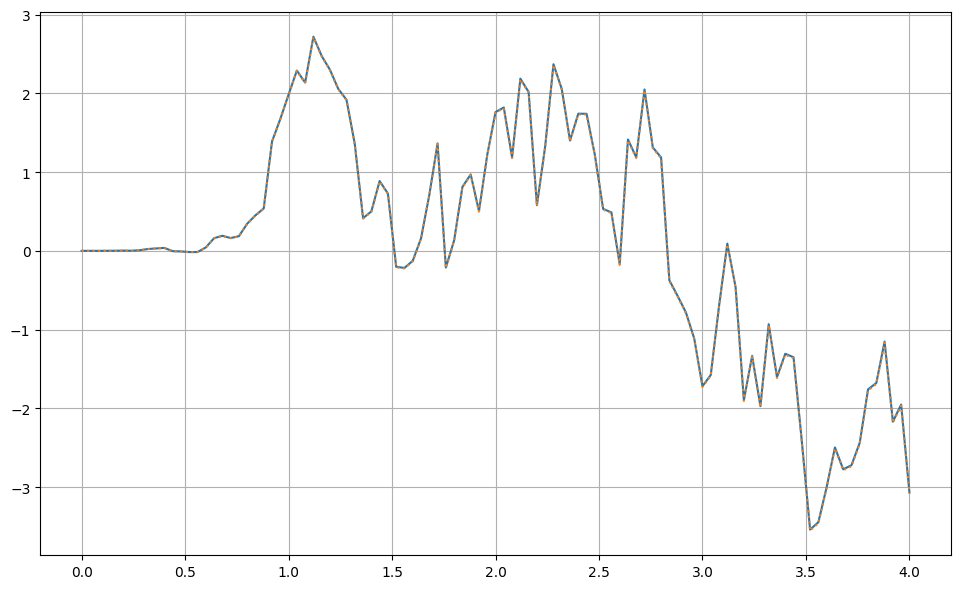

In [52]:
plt.plot(t_grid_pos, (signal_sig_coefs_exact["12"] @ Sig)[:, 0])
plt.plot(t_grid_pos, (e12 @ SignalSig)[:, 0], ":")

In [53]:
%%time
eSig = expected_signature(t=t_grid_pos, trunc=N)

CPU times: total: 344 ms
Wall time: 393 ms


In [54]:
%%time

expected_signal_sig_estimator = dict()
expected_signal_sig_exact = dict()

for idx in range(n_moments):
    word = ta.alphabet.index_to_word(idx)
    if word == "∅":
        word = ""
    expected_signal_sig_estimator[word] = SignalSig.array[idx].mean(axis=1)
    expected_signal_sig_exact[word] = (signal_sig_coefs_exact[word] @ eSig).squeeze()

CPU times: total: 0 ns
Wall time: 31.3 ms


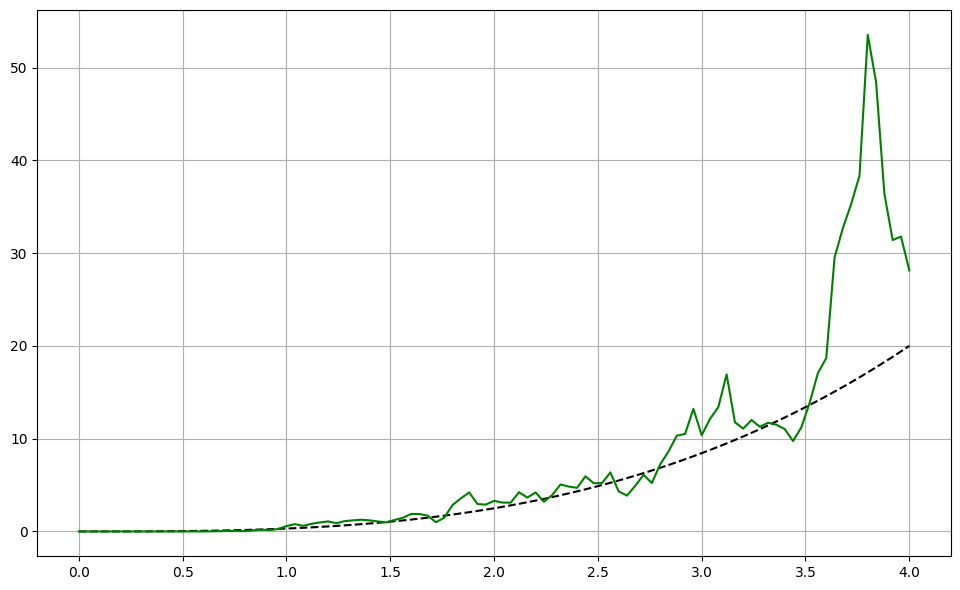

In [55]:
w = "222"
plt.plot(t_grid_pos, expected_signal_sig_exact[w], "k--")
plt.plot(t_grid_pos, expected_signal_sig_estimator[w], "g")

##### Loss functional for a given $l$

In [60]:
ell_trunc = 3

def loss(x):    
    l = ta.from_array(N, x)
    signal_sig_coefs = signal_signature_coefs_as_bm_signature_coefs(l, trunc_moments)
    
    loss = 0
    for word in words:
        if "2" in word:
            # Moments are supposed to be known exactly
            loss_word = np.sqrt(np.mean(np.abs((signal_sig_coefs[word] @ eSig).squeeze() - expected_signal_sig_exact[word])**2))
            loss += loss_word
    
    return loss

In [61]:
x0 = np.zeros(ta.alphabet.number_of_elements(ell_trunc))

In [64]:
%%time
loss(x0)

CPU times: total: 0 ns
Wall time: 28.2 ms


30.426108510889854

In [65]:
%%time

from scipy.optimize import minimize

def callback(x, f=None, context=None, accept=None, convergence=None):
    val = loss(x)
    print(f"New iteration: \n x = {x}, \n val={val}. \n")

res = minimize(loss, x0, callback=callback, method="BFGS")
print(res)

New iteration: 
 x = [0.00000000e+00 5.73625955e-02 0.00000000e+00 9.77580749e-02
 0.00000000e+00 0.00000000e+00 2.86812974e-02 1.13985344e-01
 1.88467028e-09 0.00000000e+00 4.88790387e-02 0.00000000e+00
 0.00000000e+00 4.88790368e-02 6.28223427e-10], 
 val=18.851680699502506. 

New iteration: 
 x = [0.00000000e+00 1.75144739e-01 0.00000000e+00 1.40071620e-01
 6.58770217e-09 3.29385108e-09 1.31422433e-01 2.97569780e-02
 1.27988873e-08 6.58770217e-09 1.27740843e-01 6.58770217e-09
 4.19982383e-02 1.20948642e-01 9.75604757e-09], 
 val=14.462331323872071. 

New iteration: 
 x = [0.00000000e+00 1.84719471e-01 9.44162900e-10 1.42602047e-01
 8.65965022e-09 4.84482306e-09 1.46346412e-01 2.08947714e-02
 1.57684666e-08 8.65965022e-09 1.41321835e-01 8.40215125e-09
 5.22701390e-02 1.32698284e-01 1.27014187e-08], 
 val=14.020911538998943. 

New iteration: 
 x = [ 0.00000000e+00  1.57427833e-01  3.19990418e-07  4.26519080e-01
  3.02956115e-07  3.88377096e-07  5.68094208e-01 -2.12507432e-01
  2.86189

In [66]:
l_opt = ta.from_array(moments_trunc, res.x)
ta.print(l_opt)

-0.0001749707261527009*1 + 0.012687623518143941*2 + -0.019768666252624086*11 + -0.05706982538633185*12 + 0.02636239419425755*21 + 1.0003481480379528*22 + -2.998792807214509e-07*111 + 0.015530431297588706*112 + 0.006324396457695697*121 + 0.03912291988481668*122 + -0.011320818125559243*211 + -0.04248578982503874*212 + 0.0004158927016751447*221 + -0.01867558180634447*222


In [67]:
l_Sig = l_opt @ Sig

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


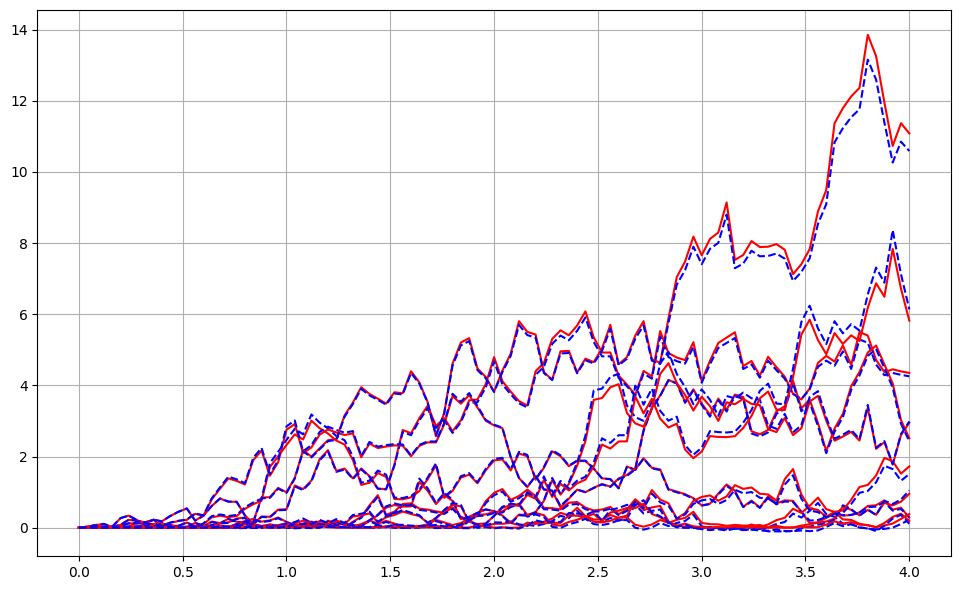

In [68]:
for i in range(10):
    plt.plot(t_grid_pos, ell_Sig[:, i], "r")
    plt.plot(t_grid_pos, l_Sig[:, i], "b--")